# Задачи к Лекции 2

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [307]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Задачи

**1. Построить наивный байесовский классификатор для количественных полей age, height, weight, ap_hi, ap_lo. Исправить данные, если это необходимо. Привести матрицу неточностей и сравнить со значением полученным в ходе лекции. Попытаться объяснить разницу.**

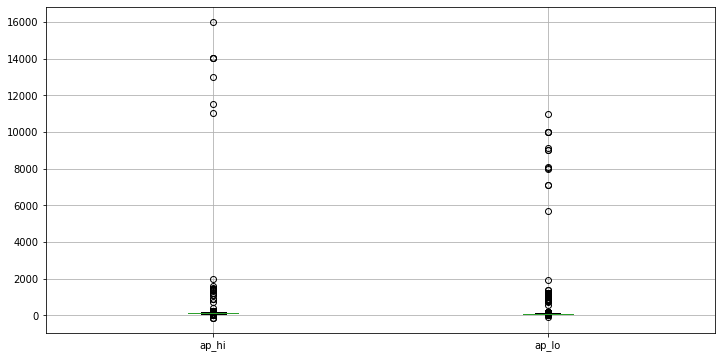

In [308]:
df[df["cardio"] == 1][['ap_hi', 'ap_lo']].boxplot();

In [309]:
data = df[((df["ap_hi"] >= 50) & (df["ap_hi"] <= 200)) & ((df["ap_lo"] >= 50) & (df["ap_lo"] <= 200))]
data['age'] = (data['age']/365.25).astype('int')

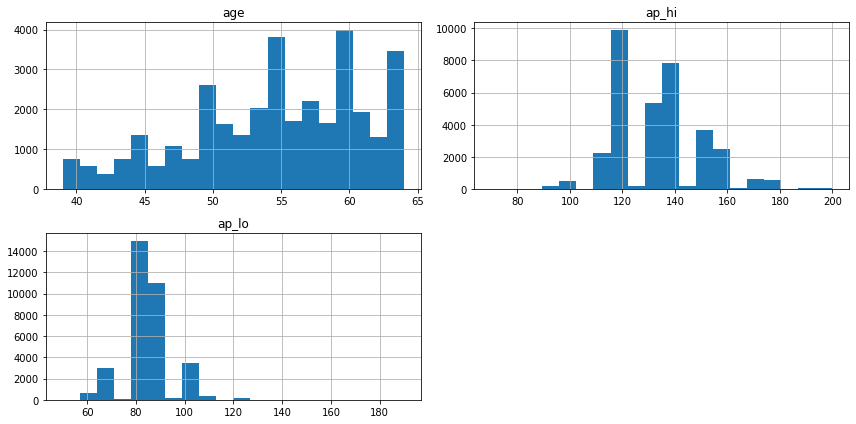

In [310]:
data[data["cardio"] == 1][["age", "ap_hi", "ap_lo"]].hist(bins=20)
plt.tight_layout();

In [311]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [320]:
X = data[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]
y = data['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

gnb = GaussianNB()

model = gnb.fit(X_train, y_train)
pred = model.predict(X_test)

ACC = accuracy_score(y_test, pred)
print(f'ACC: {ACC}')

ACC: 0.7066129736548445


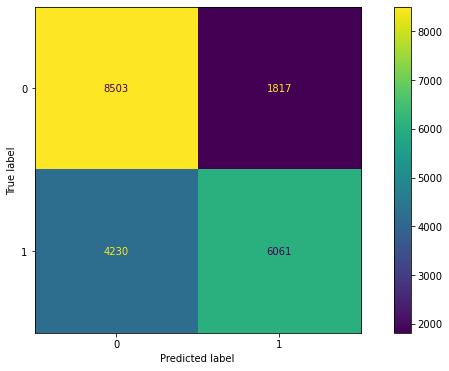

In [321]:
cnf_matrix = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot();

**Комментарии:** accuracy увеличилась на 0.8 - 0.9, потому что добавилось 2-ва количественных признака и убраны выбросы для признаков **ap_hi** и **ap_ho**

**2. Написать свой наивный байесовский классификатор для категориальных полей cholesterol, gluc. Привести матрицу неточностей и сравнить со значениями из задачи 1 (нельзя использовать готовое решение из sklearn) (не обязательно)**

In [326]:
train_df = pd.concat([pd.get_dummies(data['cholesterol'],
                                       prefix='cholesterol'),
                     pd.get_dummies(data['gluc'],
                                        prefix='gluc')], axis=1)

In [327]:
train_df.head()

,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,
0,1,0,0,1,0,0
1,0,0,1,1,0,0
2,0,0,1,1,0,0
3,1,0,0,1,0,0
4,1,0,0,1,0,0


In [329]:
X = train_df
y = data['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [342]:
from collections import defaultdict

class NaiveBayesClassifier(object):
    def __init__(self):  
        self.__class_freq = defaultdict(lambda:0)
        self.__feat_freq = defaultdict(lambda:0)


    def fit(self, X, y):
        # calculate classes and features frequencies
        for feature, label in zip(X, y):
            self.__class_freq[label] += 1
            for value in feature:
                self.__feat_freq[(value, label)] += 1

        # normalizate values
        num_samples = len(X)
        for k in self.__class_freq:
            self.__class_freq[k] /= num_samples

        for value, label in self.__feat_freq:
            self.__feat_freq[(value, label)] /= self.__class_freq[label]

        return self

    def predict(self, X):
        # return argmin of classes 
        return min(self.__class_freq.keys(), 
                key=lambda c : self.__calculate_class_freq(X, c)) 
 
    def __calculate_class_freq(self, X, clss):
        # calculate frequence for current class
        freq = - np.log(self.__class_freq[clss])
    
        for feat in X: 
            freq += - np.log(self.__feat_freq.get((feat, clss), 10 ** (-7)))
        return freq


In [331]:
model = NaiveBayesClassifier().fit(X_train.values, y_train.values)
pred = [model.predict(x) for x in X_test.values]

ACC = accuracy_score(y_test, pred)
print(f'ACC: {ACC}')

ACC: 0.5007035078356218


In [332]:
model = BernoulliNB().fit(X_train, y_train)
pred = model.predict(X_test)

ACC = accuracy_score(y_test, pred)
print(f'ACC: {ACC}')

ACC: 0.5908010285769735


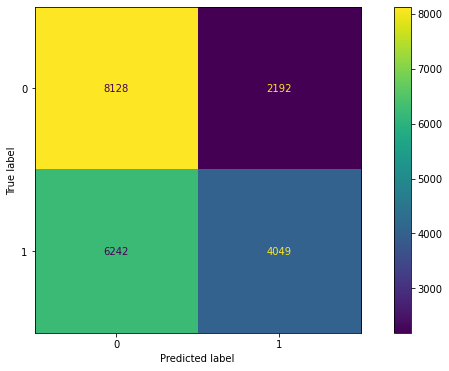

In [333]:
cnf_matrix = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot();

**Комментарии:** Ваши комментарии здесь.

**3. Построить наивный байесовский классификатор для бинарных полей gender, smoke, alco, active. Привести матрицу неточностей и сравнить с предыдущими значениями.**

In [334]:
X = data[['gender', 'smoke', 'alco', 'active']]
y = data['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

gnb = BernoulliNB()

model = gnb.fit(X_train, y_train)
pred = model.predict(X_test)

ACC = accuracy_score(y_test, pred)
print(f'ACC: {ACC}')

ACC: 0.5159380913104653


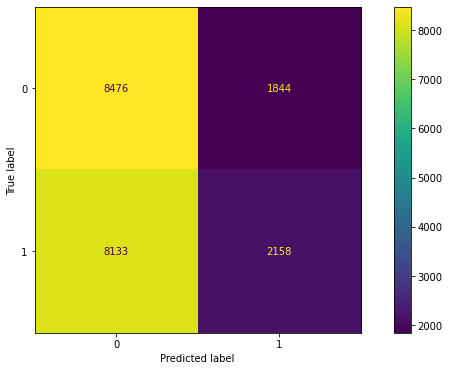

In [335]:
cnf_matrix = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot();

**Комментарии:** Ваши комментарии здесь.

**4. К этому моменту у вас есть три независимых классификатора: по количественным полям, категориальным и бинарным. Придумать, как их объединить в один единый классификатор, который учитывает все эти поля. Привести матрицу неточностей для него и сравнить с предыдущими значениями. Попытаться объяснить разницу.**

In [336]:
df_1 = pd.concat([data, train_df], axis=1)
df_1.drop(['cholesterol', 'gluc', 'cardio'], axis=1, inplace=True)

In [337]:
df_1.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,0,0,1,1,0,0,1,0,0
1,55,1,156,85.0,140,90,0,0,1,0,0,1,1,0,0
2,51,1,165,64.0,130,70,0,0,0,0,0,1,1,0,0
3,48,2,169,82.0,150,100,0,0,1,1,0,0,1,0,0
4,47,1,156,56.0,100,60,0,0,0,1,0,0,1,0,0


In [340]:
X = df_1
y = data['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

gnb = ComplementNB()

model = gnb.fit(X_train, y_train)
pred = model.predict(X_test)

ACC = accuracy_score(y_test, pred)
print(f'ACC: {ACC}')

ACC: 0.7089418271796614


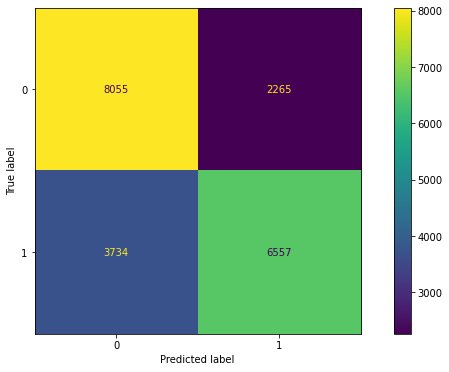

In [341]:
cnf_matrix = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot();

**Комментарии:** Лучший результат показал ComplementNB с ACC равной 0.7089418271796614, алгоритм реализованный во втором задании выдал примерно 0.69. Если попробовать различные сиды, то можно увеличить значение ACC на 0.1 - 0.2.

**5. (Не обязательно) Теперь мы умеем делать классификацию в рамках наивного предположения об независимости всех признаков. Сейчас же нужно попробовать учесть взаимосвязь между признаками через условные вероятности. Построить классификатор с учетом такой связи. Сравнить результат с ранее полученными значениями.**

In [319]:
# A lot of code here

**Комментарии:** Ваши комментарии здесь.